In [1]:
import pandas as pd
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

# Constructing Synthetic Basket

1. Calculates the cointegration score of each NASDAQ100 component present in 2018 and 2019 against the QQQ ETF for the year 2018
2. Selects subset of NASDAQ100 components that have a cointegration p-value below 0.2
3. Create a powerset of the cointegrated subset and calculate the cointegration score of the subset against the QQQ ETF
4. Select most cointegrated subset as our synthetic basket which is, by design, cointegrated with QQQ in 2018

In [2]:
tickers = pd.read_csv("../data/nasdaq_comps_2016-2020.csv")

### Engle-Granger Two-Step Method
We use the Engle-Granger Two-Step method in our initial step to calculate the cointegration between each NASDAQ100 component and the QQQ ETF.  NASDAQ100 components are chosen if they are a component during both our basket formation period (2018) and our trading period (2019).

In [3]:
tickers = list(set(tickers['2019']).intersection(set(tickers['2018'])))
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
cointegrationResultsIndividual = fn.runCointTestIndividual(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PCAR
[*********************100%***********************]  1 of 1 completed
HAS
[*********************100%***********************]  1 of 1 completed
KLAC
[*********************100%***********************]  1 of 1 completed
WDC
[*********************100%***********************]  1 of 1 completed
EXPE
[*********************100%***********************]  1 of 1 completed
ADI
[*********************100%***********************]  1 of 1 completed
NVDA
[*********************100%***********************]  1 of 1 completed
MDLZ
[*********************100%***********************]  1 of 1 completed
MELI
[*********************100%***********************]  1 of 1 completed
MYL
[*********************100%***********************]  1 of 1 completed
SNPS
[*********************100%***********************]  1 of 1 completed
INTU
[*********************100%*********************

In [4]:
cointegrationResultsIndividual.head(10)

,ticker,t-stat,pval
1,HAS,-3.476138,0.034570
82,AAPL,-3.268703,0.059170
63,TTWO,-3.186715,0.072178
91,IDXX,-3.156778,0.077458
81,SBUX,-3.125705,0.083256
73,CTAS,-3.089389,0.090454
75,ALXN,-2.892722,0.137956
12,ALGN,-2.865327,0.145781
87,BMRN,-2.797488,0.166485
80,PAYX,-2.703154,0.198446


### Synthetic Basket Construction
Based on the Engle-Granger cointegration test performed, we select the subset of the NASDAQ100 components that have a cointegration test p-value of less than 0.2 to be candidates for our synthetic basket.  We create every possible basket that can be constructed by any combination of the components in our subset and run another Engle-Granger cointegration test.  This time we run the cointegration test of the ETF against the sum of the components in our basket.  The most cointegrated synthetic basket is selected to be traded in the trading period (2019).

In [5]:
subset = cointegrationResultsIndividual.loc[cointegrationResultsIndividual['pval'] <= 0.2]
tickers = subset['ticker'].tolist()
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
synthetic_asset_rank = fn.runCointTestBasketsEG(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed
0 done, out of a total of  1013
500 done, out of a total of  1013
1000 done, out of a total of  1013


In [6]:
synthetic_asset_rank.head()

,ticker,t-stat,pval
973,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, PAYX)",-5.112294,0.000102
857,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN)",-5.082241,0.000116
972,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, BMRN)",-5.054691,0.000130
984,"(HAS, AAPL, SBUX, CTAS, ALXN, ALGN, BMRN, PAYX)",-5.047519,0.000135
1008,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, BMRN...",-5.047064,0.000135


# Constructing Multivariate Kalman Filter
1. Construct a multivariate Kalman Filter with each stock in our synthetic basket collectively filtered against QQQ for the year 2019
2. Using the outputted state means, calculate the value of our synthetic basket
3. Generate the spread between our synthetic basket and the QQQ ETF.  We expect this spread to be mean-reverting

In [7]:
# Start from 01-01-2019 and end at 12-31-2019
qqq = pd.read_csv("../data/qqqMinute2019.csv")
has = pd.read_csv("../data/hasMinute2019.csv")
aapl = pd.read_csv("../data/aaplMinute2019.csv")
ttwo = pd.read_csv("../data/ttwoMinute2019.csv")
sbux = pd.read_csv("../data/sbuxMinute2019.csv")
ctas = pd.read_csv("../data/ctasMinute2019.csv")
alxn = pd.read_csv("../data/alxnMinute2019.csv")
algn = pd.read_csv("../data/algnMinute2019.csv")
payx = pd.read_csv("../data/payxMinute2019.csv")

In [8]:
qqq = qqq.set_index('date_time')
qqq = qqq.rename(columns={'close': 'qqqclose'})

has = has.set_index('date_time')
has = has.rename(columns={'close': 'hasclose'})

aapl = aapl.set_index('date_time')
aapl = aapl.rename(columns={'close': 'aaplclose'})

ttwo = ttwo.set_index('date_time')
ttwo = ttwo.rename(columns={'close': 'ttwoclose'})

sbux = sbux.set_index('date_time')
sbux = sbux.rename(columns={'close': 'sbuxclose'})

ctas = ctas.set_index('date_time')
ctas = ctas.rename(columns={'close': 'ctasclose'})

alxn = alxn.set_index('date_time')
alxn = alxn.rename(columns={'close': 'alxnclose'})

algn = algn.set_index('date_time')
algn = algn.rename(columns={'close': 'algnclose'})

payx = payx.set_index('date_time')
payx = payx.rename(columns={'close': 'payxclose'})

data = qqq[['qqqclose']].join([has[['hasclose']], aapl[['aaplclose']], ttwo[['ttwoclose']], sbux[['sbuxclose']], 
                               ctas[['ctasclose']], alxn[['alxnclose']], algn[['algnclose']], payx[['payxclose']]], 
                              how='outer')
data = data.dropna()
data.tail(20)

,qqqclose,hasclose,aaplclose,ttwoclose,sbuxclose,ctasclose,alxnclose,algnclose,payxclose
2019-12-31 15:30:00,212.345,105.7300,293.1700,122.2000,87.6850,268.2800,108.0100,277.8000,84.8400
2019-12-31 15:31:00,212.330,105.7100,293.1768,122.1600,87.7050,268.3100,107.9500,277.5900,84.8500
2019-12-31 15:32:00,212.355,105.6972,293.1400,122.1200,87.7130,268.3200,107.9500,277.8300,84.8600
2019-12-31 15:33:00,212.360,105.6900,293.0200,122.1800,87.7250,268.4400,107.9550,277.8800,84.8700
2019-12-31 15:34:00,212.365,105.6900,293.0165,122.2200,87.7700,268.4900,107.9700,277.8200,84.8900
2019-12-31 15:35:00,212.385,105.6800,293.0170,122.1800,87.7650,268.4800,107.9850,278.1000,84.9100
2019-12-31 15:36:00,212.370,105.6500,292.9450,122.2000,87.7600,268.4793,108.0387,278.0950,84.8800
2019-12-31 15:37:00,212.350,105.6200,293.0400,122.1700,87.7600,268.4900,107.9800,277.8700,84.8800
2019-12-31 15:38:00,212.385,105.6200,293.1316,122.1298,87.7600,268.5600,108.0000,278.1000,84.9000
2019-12-31 15:39:00,212.355,105.6044,293.0800,122.1050,87.7500,268.5800,108.0300,278.0050,84.9300


In [9]:
syntheticAssetLogPrice = data[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                               'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].apply(np.log)
qqqLogPrice = np.log(data['qqqclose'].values)

### Multivariate Kalman Filter
At every timestep, the Kalman Filter outputs estimates for the hedge ratios of each component in our synthetic basket as well as an intercept term.  In other words, it gave us all the tools to calculate an estimate for the price of QQQ based on the price of each component in our basket.  The residuals of this estimate form a mean-reverting and stationary process that we can take advantage of.  

We model QQQ price with the following formula:
$$ \widehat{price_{QQQ}} = \sum_{n=1}^{N} \beta_{n} * price_{n} $$

Using the Kalman Filter, we are able to calculate what the values for $ \beta_{n} $ are for each time-period.

We expect the residuals of this model to be mean-reverting and stationary.

$$ residuals = price_{QQQ} - \widehat{price_{QQQ}} $$

In [10]:
kf = fn.multivariateKalmanFilter(syntheticAssetLogPrice, qqqLogPrice)
state_means, state_covs = kf.filter(qqqLogPrice)
basket_size = len(syntheticAssetLogPrice.columns)
slopes = state_means[:, np.arange(0, basket_size, 1)]
#intercept = state_means[:, basket_size]

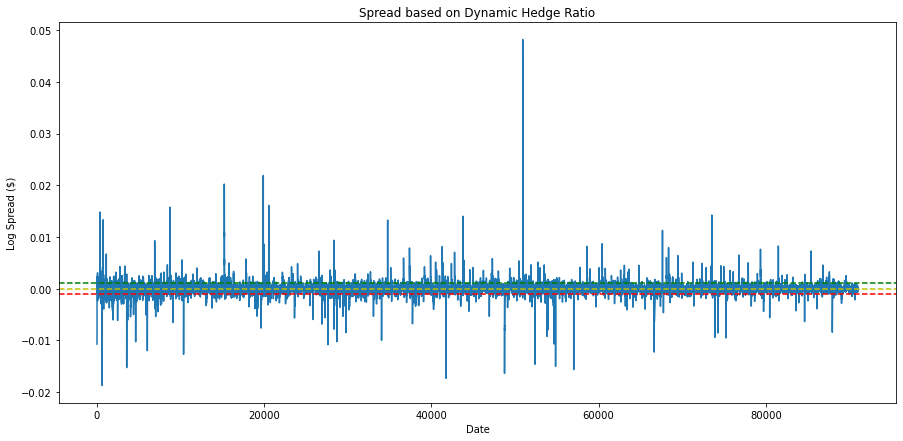

In [11]:
syntheticAssetEstimate = [np.dot(slopes[i], syntheticAssetLogPrice.values[i].T) for i in range(len(slopes))]
spread_ts = qqqLogPrice - syntheticAssetEstimate
plt.figure(figsize = (15,7))
plt.plot(spread_ts)
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Log Spread ($)")
plt.xlabel("Date")
spread_avg = spread_ts.mean()
spread_sd = spread_ts.std()
upper_threshold = spread_avg + spread_sd
lower_threshold = spread_avg - spread_sd
plt.axhline(upper_threshold, linestyle = 'dashed', color = 'g')
plt.axhline(spread_avg, linestyle = 'dashed', color = 'y')
plt.axhline(lower_threshold, linestyle = 'dashed', color = 'r')

# Building our Strategy
1. Using minute level data from 2018, optimize our strategy parameters by simulating the strategy performance in 2018 with different parameter combinations.  Pick the parameters that give us the highest return in 2018 and use those parameters for our strategy in 2019.
2. Build a Bollinger Band strategy using the lookback and z-score threshold outputted by our parameter tuning module.  When the spread breaks above/below our upper/lower bands, we enter a short/long position on the spread in the minute immediately after.

## Parameter Tuning for Bollinger Bands
On the formation period, simulate trading according to different lookback periods and z-score thresholds for the Bollinger Bands.  The most promising set of parameters (according to profit or Sharpe Ratio) are then used for our trading period.  Also construct the Kalman Filter and calculate the threshold for the bottom 20% of the spread difference between two minutes.  This threshold will be used to optimize our entries and exits.

In [12]:
# Start from 01-01-2018 and end at 12-31-2018
qqq2018 = pd.read_csv("../data/qqqMinute2018.csv")
has2018 = pd.read_csv("../data/hasMinute2018.csv")
aapl2018 = pd.read_csv("../data/aaplMinute2018.csv")
ttwo2018 = pd.read_csv("../data/ttwoMinute2018.csv")
sbux2018 = pd.read_csv("../data/sbuxMinute2018.csv")
ctas2018 = pd.read_csv("../data/ctasMinute2018.csv")
alxn2018 = pd.read_csv("../data/alxnMinute2018.csv")
algn2018 = pd.read_csv("../data/algnMinute2018.csv")
payx2018 = pd.read_csv("../data/payxMinute2018.csv")

In [13]:
qqq2018 = qqq2018.set_index('date_time')
qqq2018 = qqq2018.rename(columns={'close': 'qqqclose'})

has2018 = has2018.set_index('date_time')
has2018 = has2018.rename(columns={'close': 'hasclose'})

aapl2018 = aapl2018.set_index('date_time')
aapl2018 = aapl2018.rename(columns={'close': 'aaplclose'})

ttwo2018 = ttwo2018.set_index('date_time')
ttwo2018 = ttwo2018.rename(columns={'close': 'ttwoclose'})

sbux2018 = sbux2018.set_index('date_time')
sbux2018 = sbux2018.rename(columns={'close': 'sbuxclose'})

ctas2018 = ctas2018.set_index('date_time')
ctas2018 = ctas2018.rename(columns={'close': 'ctasclose'})

alxn2018 = alxn2018.set_index('date_time')
alxn2018 = alxn2018.rename(columns={'close': 'alxnclose'})

algn2018 = algn2018.set_index('date_time')
algn2018 = algn2018.rename(columns={'close': 'algnclose'})

payx2018 = payx2018.set_index('date_time')
payx2018 = payx2018.rename(columns={'close': 'payxclose'})

data2018 = qqq2018[['qqqclose']].join([has2018[['hasclose']], aapl2018[['aaplclose']], ttwo2018[['ttwoclose']], 
                                       sbux2018[['sbuxclose']], ctas2018[['ctasclose']], alxn2018[['alxnclose']], 
                                       algn2018[['algnclose']], payx2018[['payxclose']]], 
                                      how='outer')
data2018 = data2018.dropna()

In [14]:
#lookback_list = np.arange(30, 301, 30)
#z_thresh_list = np.arange(1, 2.6, .25)
#results_map = fn.tuneBBParameters(data2018, lookback_list, z_thresh_list, 
#                                  ['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
#                                   'ctasclose', 'alxnclose', 'algnclose', 'payxclose'], 
#                                 stoploss = None)

In [15]:
#params = list(results_map.keys())[0]
#print(params)

In [16]:
syntheticAssetLogPrice2018 = data2018[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                               'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].apply(np.log)
qqqLogPrice2018 = np.log(data2018['qqqclose'].values)

In [17]:
kf2018 = fn.multivariateKalmanFilter(syntheticAssetLogPrice2018, qqqLogPrice2018)
state_means2018, state_covs2018 = kf2018.filter(qqqLogPrice2018)
basket_size2018 = len(syntheticAssetLogPrice2018.columns)
slopes2018 = state_means2018[:, np.arange(0, basket_size2018, 1)]
#intercept2018 = state_means2018[:, basket_size2018]

In [18]:
hedge_ratios2018 = np.asarray([slopes2018.T[i] for i in range(len(slopes2018.T))]).T
hedge_ratios2018 = pd.DataFrame(hedge_ratios2018, columns=['hasHR', 'aaplHR', 'ttwoHR', 'sbuxHR', 'ctasHR', 
                                                          'alxnHR', 'algnHR', 'payxHR'])

In [19]:
syntheticAssetEstimate2018 = [np.dot(slopes2018[i], syntheticAssetLogPrice2018.values[i].T) for i in range(len(slopes2018))]
spread_ts2018 = qqqLogPrice2018 - syntheticAssetEstimate2018
data2018.reset_index(inplace=True)
data2018 = data2018.rename(columns={'index': 'datetime'})
data2018['spread'] = np.exp(spread_ts2018)
backtest_data2018 = data2018[['datetime', 'qqqclose', 'hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                      'ctasclose', 'alxnclose', 'algnclose', 'payxclose', 'spread']]

In [20]:
diff_thresh = fn.calculateDiffThresh(backtest_data2018, q=0.2)
print(diff_thresh)

In [21]:
#backtest_data2018.to_csv("../backtest_data_entries_exits_2018.csv")
#hedge_ratios2018.to_csv("../hedge_ratios_2018.csv")

## Bollinger Band Strategy
The Bollinger Band strategy considers volatility when constructing entries and exits.  A lookback period is chosen and an exponential moving average is computed for that lookback period.  A constant is also chosen that represents how many standard deviations the bands should encompass.  When the spread exceeds the upper band, a short signal is generated.  When the spread is below the lower band, a long signal is generated.  The signal ends when the spread crosses the exponential moving average again.  Note, the actual positions we take need to be lagged by 1 minute from our signals.  Without this shift, our results would be reliant on high-frequency trading technology and latency.  Positions are also closed by the end of the day and no overnight positions are ever taken.

In [22]:
data.reset_index(inplace=True)
data['logspread'] = spread_ts
data['spread'] = np.exp(spread_ts)
data = data.rename(columns={'index': 'datetime'})

In [59]:
backtest_data = data[['datetime', 'qqqclose', 'hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                      'ctasclose', 'alxnclose', 'algnclose', 'payxclose', 'spread']]
lookback = 300 #params[0]
z_thresh = 1.5 #params[1].round(2)

In [60]:
backtest_data = fn.createBands(backtest_data, lookback, z_thresh)

Text(0.5, 0, 'Date')

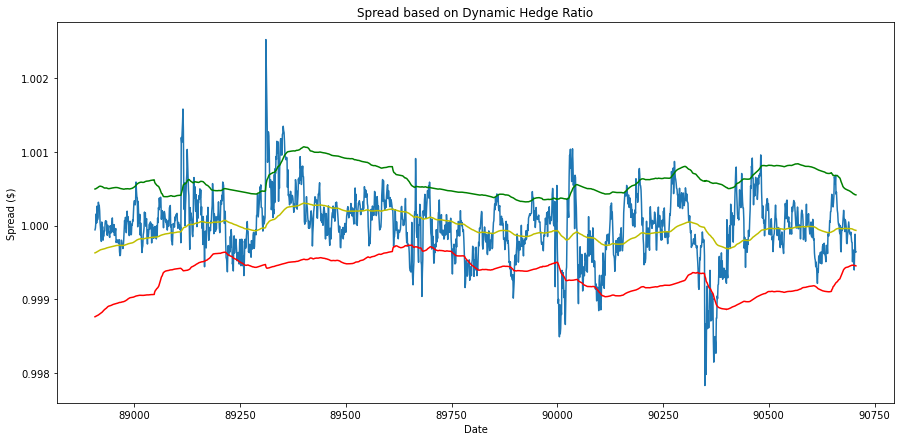

In [61]:
plt.figure(figsize = (15,7))
plt.plot(backtest_data['spread'].iloc[-1800:])
plt.plot(backtest_data['upperband'].iloc[-1800:], color='g')
plt.plot(backtest_data['ema'].iloc[-1800:], color='y')
plt.plot(backtest_data['lowerband'].iloc[-1800:], color='r')
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Spread ($)")
plt.xlabel("Date")

In [62]:
#backtest_data = fn.createPositions(backtest_data) # no overnight positions, all positions exited by EOD
backtest_data = fn.createOptimalPositions(backtest_data, threshold=diff_thresh)

C:\Users\liuvi\anaconda3\envs\quant\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Trade Log
The trade log is generated to compile all the individual trades executed in our backtest and some information about them.  This includes the start and end time, the holding period, what position was taken (long or short), position size and value, as well as profit and return information.  The information in this dataset can be used to analyze the strategy and the properties of the trades executed by the strategy.

In [63]:
prices = backtest_data[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                       'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].values
hedge_ratios = np.asarray([slopes.T[i][lookback - 1:] for i in range(len(slopes.T))]).T

In [64]:
tradeLog, minuteDf = fn.constructTradeLog(backtest_data['datetime'].values, backtest_data['position'].values,
                               backtest_data['qqqclose'].values, prices, 
                               hedge_ratios.round(3), stoploss = None,
                               lot_size = 1000)
tradeLog.tail()

,start,end,holdingPeriod,position,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,initialPortfolioValue,trade_profit,trade_returns,trade_profit2
620,2019-12-30 12:37:00,2019-12-30 13:17:00,38,short,1000,212.665,212.6050,"[76.0, 249.0, 111.0, 67.0, 220.0, 96.0, 136.0,...","[106.095, 291.6299, 123.195, 87.58, 268.14, 10...","[106.03, 291.58, 123.25, 87.475, 268.74, 107.7...",425890.2901,53.3449,0.000125,NaN
621,2019-12-30 15:38:00,2019-12-30 15:50:00,12,long,1000,212.220,212.2099,"[76.0, 249.0, 111.0, 67.0, 220.0, 96.0, 136.0,...","[105.23, 292.376, 122.3, 87.345, 268.1819, 107...","[105.24, 292.09, 122.31, 87.3655, 268.3353, 10...",425216.0294,30.8549,0.000073,NaN
622,2019-12-31 10:02:00,2019-12-31 10:37:00,33,long,1000,212.210,211.9248,"[76.0, 249.0, 111.0, 67.0, 220.0, 96.0, 136.0,...","[105.91, 292.1, 122.1998, 87.7, 269.37, 107.36...","[106.129, 291.5695, 121.94, 87.5953, 269.05, 1...",425805.6250,-265.7496,-0.000624,NaN
623,2019-12-31 11:04:00,2019-12-31 11:24:00,19,short,1000,211.790,211.7913,"[76.0, 249.0, 111.0, 67.0, 220.0, 96.0, 135.0,...","[105.9499, 291.53, 121.95, 87.565, 267.8888, 1...","[106.0089, 291.9301, 121.8, 87.57, 267.975, 10...",424673.4354,87.3659,0.000206,NaN
624,2019-12-31 11:44:00,2019-12-31 12:14:00,30,short,1000,211.785,211.8158,"[76.0, 249.0, 111.0, 67.0, 220.0, 96.0, 135.0,...","[105.9107, 292.033, 121.68, 87.6922, 267.33, 1...","[105.7739, 291.9101, 121.92, 87.49, 267.385, 1...",424443.2376,-5.8563,-0.000014,NaN


<ipython-input-65-4913ea6083e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_df['cumulative_returns'] = np.cumprod(1 + minuteDf['returns'])


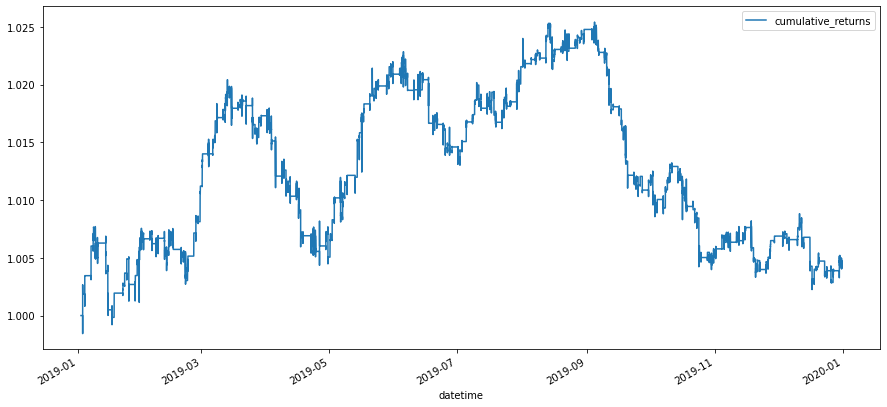

In [65]:
returns_df = minuteDf[['datetime']]
returns_df['cumulative_returns'] = np.cumprod(1 + minuteDf['returns'])
returns_df = returns_df.set_index('datetime')
returns_df.plot(figsize=[15, 7])

In [66]:
total_profit = tradeLog['trade_profit'].sum()
print('Trade Log cumulative profit was {:.3f}'.format(total_profit))

Trade Log cumulative profit was 1166.830


In [67]:
cumulative_return = np.cumprod(1 + tradeLog['trade_returns']) - 1
print('Trade Log cumulative return was {:.3f}%'.format(cumulative_return.iloc[-1] * 100))

Trade Log cumulative return was 0.471%


In [68]:
minuteDf['datetime'] = pd.to_datetime(minuteDf['datetime'])
dailyReturns = fn.calculateDailyReturns(minuteDf[['datetime', 'returns']])
sharpeRatio = fn.calculateAnnualizedSharpeRatio(dailyReturns)
print('Annualized Sharpe Ratio: ', sharpeRatio)

Annualized Sharpe Ratio:  0.26357972993172335


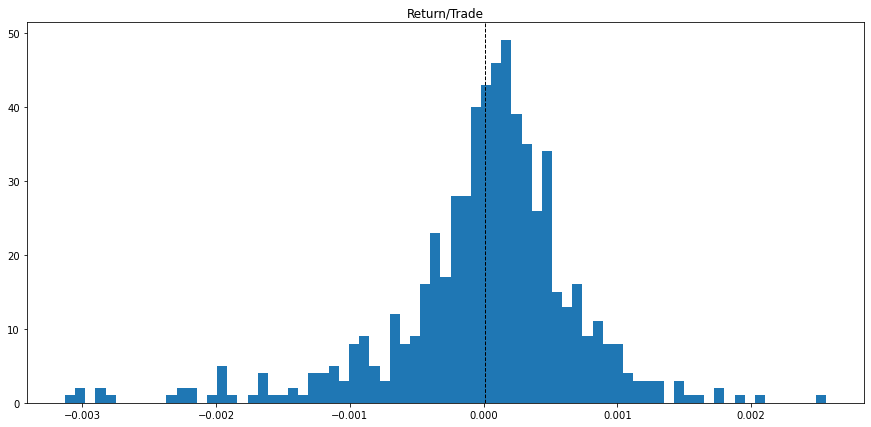

In [69]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['trade_returns'], bins=75)
plt.axvline(tradeLog['trade_returns'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Return/Trade")
plt.show()

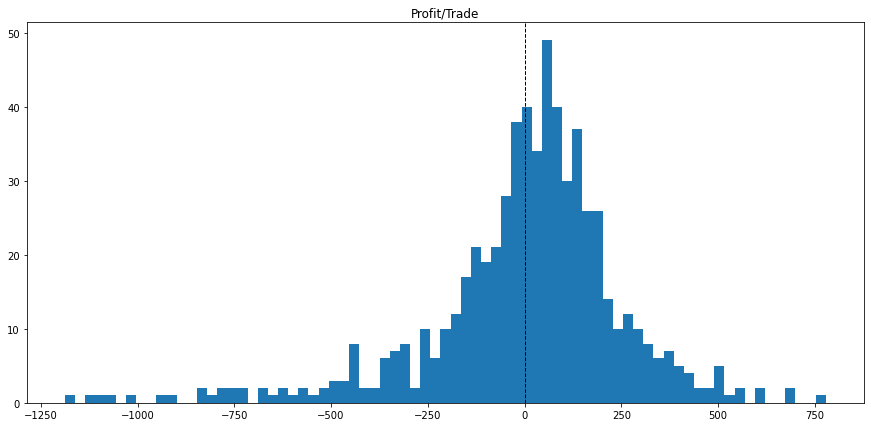

In [70]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['trade_profit'], bins=75)
plt.axvline(tradeLog['trade_profit'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Profit/Trade")
plt.show()

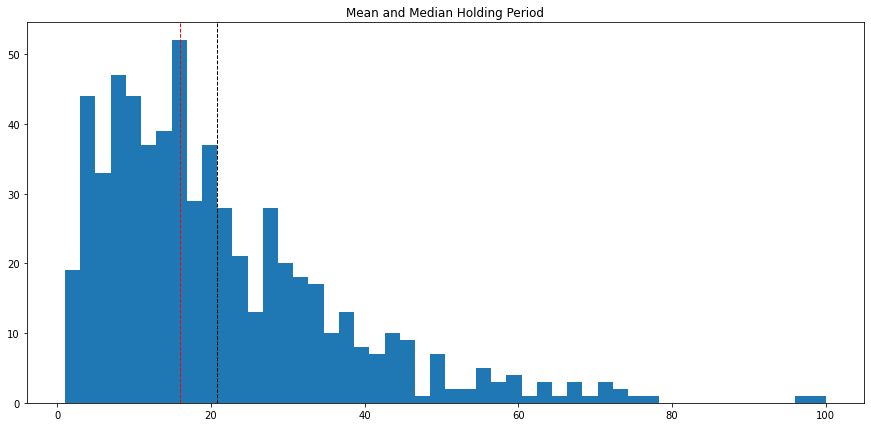

In [71]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['holdingPeriod'], bins=50)
plt.axvline(tradeLog['holdingPeriod'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tradeLog['holdingPeriod'].median(), color='r', linestyle='dashed', linewidth=1)
plt.title("Mean and Median Holding Period")
plt.show()